In [1]:
# Import required libraries
import numpy as np
import quaternion
import pyulog

In [2]:
class CircularBuffer:
    """
    Class implement circular buffer.
    """
    def __init__(self, length : int, data_type : np.dtype) -> None:
        """
        Constructor CircularBuffer

        Parameters
        ----------
        lenght : unsigned int
            Buffor length (size).
        
        data_type : numpy.dtype
            Type of data stored in buffer.
        """
        self.length     = length
        self.data_type  = data_type
        self.buffer     = np.zeros((length,1), dtype=data_type)
        self.pointer    = 0


    def push(self, element : np.dtype,) -> None:
        """
        Push element on top FIFO list
        
        Parameters
        ----------
        element : self.data_type
            Element to add
        """
        self.pointer = self.pointer % self.length
        self.buffer[self.pointer ] = element
        self.pointer += 1 


    def get_buffor(self) -> np.array:
        """
        Fuction return buffer in FIFO sequence 
        
        Returns
        -------
        buffer : numpy.array
            Buffer in FIFO sequence        
        """
        return np.roll(self.buffer, self.length-self.pointer)[::-1]

In [3]:
def read_attitude_quaternions(file):
    """
    Read quaternions from ulog field vehicle attitude

    Parameters
    ----------
    file : str
        Path to ulog file

    Returns
    -------
    quat : numpy.array(dtype=numpy.quaternion)
        Array of quaternions
    timestamp : numpy.array
        Array of timestamp
    """

    log = pyulog.ULog(file) # Read datalog #TODO check warning
    v_attitude = log.get_dataset('vehicle_attitude')
    data_size  = v_attitude.data['q[0]'].shape[0]
    merged     = zip(v_attitude.data['q[0]'], 
                     v_attitude.data['q[1]'],
                     v_attitude.data['q[2]'],
                     v_attitude.data['q[3]'])

    quat = np.zeros((data_size), dtype=np.quaternion)
    for i, m in enumerate(merged):
        quat[i] = np.quaternion(m[0], m[1], m[2], m[3])
    
    return quat, v_attitude.data['timestamp']

In [4]:
quat, t_stamp = read_attitude_quaternions('./ulog/37_bs78_out_GPS_alt2pos.ulg')

In [5]:
def quaternion_interpolation(quat_one: np.quaternion, quat_two: np.quaternion, t: float) -> np.quaternion:
    """Quaternion spherical linear interpolation

    Args:
        quat_one (np.quaternion): First quaternion
        quat_two (np.quaternion): Secound quaternion
        t (float): Normalized range quat_one -> quat_two

    Returns:
        np.quaternion: Return interpolated quaternion
    """
    return (quat_two * quat_one.inverse())**t * quat_one

In [6]:
def quaternions_avg_value(quat_one, quat_two, t=0.5) -> np.quaternion:
    """Interpolation  quaternion avarage value 
    basic on spherical linear interpolation
    
    Parameters
    ----------
    quat_one : numpy.quaternion
        First quaternion
    quat_two : numpy.quaternion
        Secound quaternion

    Returns
    -------
    quat_avg : numpy.quaternion
        Return interpolated average quaternion
    """
    return quaternion_interpolation(quat_one, quat_two, 0.5)

In [7]:
def quaternions_dot(arr_1, arr_2):
    #TODO Check correct mathematical implementation
    dot = np.quaternion(0,0,0,0)
    for q1, q2 in zip(arr_1, arr_2):
        dot += q1 * q2

    return dot

In [8]:
def quaternion_autocorrelation(arr):
    r_size = arr.shape[0]
    r = np.zeros((r_size), dtype=np.quaternion)

    for m in range(r_size):
        mth_quat = arr[m]
        for q in arr:
            r[m] += quaternions_avg_value(q, mth_quat)
    
    return r

In [9]:
# Rozmiar filtru
from random import randint


P = 8

offset = randint(0,4000)
# Wyznaczenie macierzy autokorelacji
r_mat = quaternion_autocorrelation(quat[offset:offset+P][::-1])

# Algorytm LD
a_arr = np.zeros((0), dtype=np.quaternion)
r_arr = np.zeros((0), dtype=np.quaternion)

r0 = 1

# Dla P=1
a_arr = np.append(a_arr, r_mat[0])
r_arr = np.append(r_arr, r_mat[0])

# Iteracyjne wyzaczenie wsp.
for i in range(1, P):
    temp_a = (r_mat[i]-quaternions_dot(r_arr[::-1],a_arr))* (r0 - quaternions_dot(r_arr[::-1],a_arr[::-1])).inverse()
    a_arr = np.append(a_arr, temp_a)
    for j in range(i):
        a_arr[j] = a_arr[j] - temp_a * a_arr[i-j-1]

    r_arr = np.append(r_arr, r_mat[i])

print("Filter coefficient: \n", a_arr)

Filter coefficient: 
 [quaternion(-0.111154372403175, 4.09461669847683e-05, -8.91946599835067e-06, -0.000112945014365235)
 quaternion(-0.000679762405760412, 0.000213130519782739, -0.000507751411054178, 0.0085209568038807)
 quaternion(0.0233630085010157, 6.87091104064876e-05, -0.000162195186886708, 0.00271254147664826)
 quaternion(0.212798309366398, 7.21017970767891e-05, -0.000234018877483536, 0.0042895527248611)
 quaternion(0.294266930308472, -4.10792407284874e-06, -6.12976147443941e-05, 0.00144480759907784)
 quaternion(0.312334036278562, -5.48150582265419e-05, 8.2279012314546e-05, -0.00111792424546995)
 quaternion(0.299831557909852, -5.39252708387499e-05, 9.81990938558869e-05, -0.00161503211308166)
 quaternion(0.258287994515581, -7.58863261456156e-05, 0.000191436446046056, -0.00342968396507434)]


In [10]:
# Tests 
buffor = CircularBuffer(P, np.quaternion)

start_address = randint(0,4000)

for i in range(P):   # Load buffor 
    buffor.push(quat[start_address])
    start_address += 1

for _ in range(10):
    print('EX: ',quat[start_address])
    print('Est: ',quaternions_dot(a_arr, buffor.get_buffor()[:-1]))
    start_address += 1
    buffor.push(quat[start_address])

EX:  quaternion(0.875606715679169, 0.00993635877966881, -0.0269330441951752, 0.48217099905014)
Est:  [quaternion(0.895667680507197, 0.0104900940581996, -0.0284240484637198, 0.50944130970462)]
EX:  quaternion(0.875583410263062, 0.00993703957647085, -0.0269442237913609, 0.482212662696838)
Est:  [quaternion(0.895687931889591, 0.0105038124460062, -0.0284228680874151, 0.509405099055396)]
EX:  quaternion(0.875552654266357, 0.0099456338211894, -0.0269401632249355, 0.482268452644348)
Est:  [quaternion(0.895708543503975, 0.0105166828462035, -0.0284209065008307, 0.509365870126903)]
EX:  quaternion(0.875463962554932, 0.00995446834713221, -0.026887558400631, 0.482432246208191)
Est:  [quaternion(0.895733732615307, 0.0105273916549342, -0.0284203928680848, 0.509318223155735)]
EX:  quaternion(0.87545907497406, 0.00994109641760588, -0.0268990360200405, 0.482440710067749)
Est:  [quaternion(0.895730558416241, 0.0105230990659253, -0.028422856689144, 0.509319343151285)]
EX:  quaternion(0.875463128089905, 0

Timestamp diff: 2004.0


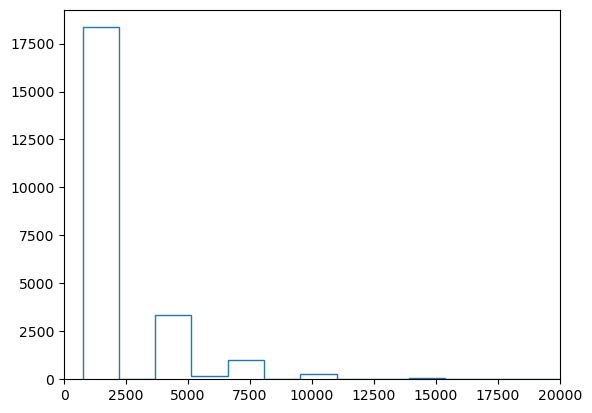

In [11]:
import matplotlib.pyplot as plt

t_stamp_diff = np.diff(t_stamp)
t_stamp_diff_median = np.median(t_stamp_diff)


print("Timestamp diff: {}".format(t_stamp_diff_median))
counts, bins = np.histogram(t_stamp_diff[:np.argmax(t_stamp_diff)], bins=20)
plt.stairs(counts, bins)
plt.xlim(0,2e4)
plt.show()

In [12]:
val = np.random.randint(0, np.argmax(t_stamp_diff))

for i in range(val, val+6, 2):
    print("Sample {}: t_stamp: {}, quat: {}".format(i,t_stamp[i],quat[i]))


t = t_stamp_diff_median/(t_stamp[val+2]-t_stamp[val])
est = quaternion_interpolation(quat[val], quat[val+2], t)
print("\n")
print("EST : t_stamp: {}, quat: {}".format(int(t_stamp[val]+t_stamp_diff_median), est))
print("REAL: t_stamp: {}, quat: {}".format(t_stamp[val+1], quat[val+1]))

dif = est-quat[val+1]
print(dif)
mse = np.sqrt(dif.w**2 + dif.x**2 + dif.y**2 + dif.z**2)
print("MSE error: {}".format(mse))

Sample 17459: t_stamp: 107478181, quat: quaternion(0.935122191905975, -0.017879843711853, -0.00252507347613573, 0.353865087032318)
Sample 17461: t_stamp: 107482182, quat: quaternion(0.93519127368927, -0.0181986354291439, -0.00257693021558225, 0.353666126728058)
Sample 17463: t_stamp: 107488178, quat: quaternion(0.93529862165451, -0.0187404621392488, -0.00268375012092292, 0.353352576494217)


EST : t_stamp: 107480185, quat: quaternion(0.93515681060657, -0.0180395187708089, -0.00255104725527723, 0.35376543941289)
REAL: t_stamp: 107480178, quat: quaternion(0.9351567029953, -0.0180380009114742, -0.00254847295582294, 0.353765696287155)
quaternion(1.07611269228869e-07, -1.51785933468623e-06, -2.57429945428123e-06, -2.56874265580631e-07)
MSE error: 3.001412869598151e-06


In [13]:
np.max(t_stamp_diff)

382000